In [1]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, LeakyReLU, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds

In [2]:
def build_generator(img_size, latent_dim):
    z = Input(latent_dim)
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(z)
    x = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(x)
    x = Conv2DTranspose(img_size[-1],(3,3),strides=(2,2),padding="same", activation = tf.nn.leaky_relu)(x)
    return Model(z, x)

def build_encoder(img_size, latent_dim):
    x = Input(img_size)
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(x)
    y = Conv2D(128, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(256, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(512, (3, 3), padding="same", activation = tf.nn.leaky_relu)(y)
    y = Conv2D(latent_dim[-1],(3,3),strides=(2,2),padding="same")(y)
    return Model(x,y)

def build_discriminator(img_size, latent_dim):
    x = Input(img_size)
    z = Input(latent_dim)
    _z = Flatten()(z)
    _z = Dense(img_size[0]*img_size[1]*img_size[2])(_z)
    _z = Reshape(img_size)(_z)

    y = Concatenate()([x,_z])
    y = Conv2D(128, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(128, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(256, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(256, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(512, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(512, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), strides=(2, 2), padding="same")(y)
    y = LeakyReLU()(y)
    y = Conv2D(1024, (3, 3), padding="same")(y)
    y = LeakyReLU()(y)
    y = Flatten()(y)
    y = Dense(1)(y)
    return Model([x, z], [y])



In [3]:
def load_dataset(data_dir, img_size = 64, batch_size = 1):
    df = tf.keras.utils.image_dataset_from_directory(directory = data_dir, 
                                                     labels = None, 
                                                     batch_size= None,
                                                     image_size = (img_size, img_size),
                                                     seed = 42)
    
    return df

In [4]:
data_folder = "sample_data/"
img_dim = 32
train_ds = load_dataset(data_folder+"img", img_size = img_dim, batch_size = 1)

Found 2560 files belonging to 1 classes.


2023-03-23 04:40:41.719118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 04:40:41.735247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 04:40:41.738162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 04:40:41.742888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
def apply_norm(x):
    return (x*2)/255.0 - 1

In [6]:
latent_dim = (2,2,32)
img_size = (img_dim, img_dim, 3)

enc = build_encoder(img_size, latent_dim)
gen = build_generator(img_size, latent_dim)
disc = build_discriminator(img_size, latent_dim)

g_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
e_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)
d_opt = Adam(learning_rate = 1e-4,  beta_1=0.0, beta_2=0.9)


In [7]:
num = len(train_ds)

train_ds = train_ds.map(apply_norm)
train_ds = tfds.as_numpy(train_ds)

z_train = np.random.uniform(-1.0, 1.0, (num, )+latent_dim).astype("float32")

In [8]:
import random

t = list(zip(train_ds, z_train))
random.shuffle(t)
train_ds, z_train = zip(*t)

train_ds = np.array(train_ds)
z_train = np.array(z_train)

In [9]:
epochs = 200
batch_size = 128

In [10]:
X_train = train_ds.reshape(-1, batch_size, img_dim, img_dim, 3)
z_train = z_train.reshape(-1, batch_size, latent_dim[0], latent_dim[1], latent_dim[2])

In [11]:
for epoch in tqdm(range(epochs), desc='Total'):
    
    running_loss = [0,0,0]
    num_steps = num//batch_size
    
    perm = np.random.permutation(X_train.shape[0])
    
    X_train = X_train[perm]
    z_train = z_train[perm]
    
    for steps in range(0, num_steps):
        x_batch = X_train[steps]
        z_batch = z_train[steps]
        
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:      
            fake_img = gen(z_batch)
            fake_z = enc(x_batch)

            preds = disc([tf.concat([fake_img, x_batch], axis = 0) , tf.concat([z_batch, fake_z], axis = 0)])
            pred_gen, pred_enc = tf.split(preds, 2)
            
            gen_loss = tf.reduce_mean(tf.nn.softplus(pred_gen))
            enc_loss = tf.reduce_mean(tf.nn.softplus(-pred_enc))
            disc_loss = tf.reduce_mean(tf.nn.softplus(-pred_gen)) + tf.reduce_mean(tf.nn.softplus(pred_enc))

        gen_grad = tape.gradient(gen_loss, gen.trainable_variables)
        disc_grad = tape.gradient(disc_loss, disc.trainable_variables)
        enc_grad = tape.gradient(enc_loss, enc.trainable_variables)

        g_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
        e_opt.apply_gradients(zip(enc_grad,enc.trainable_variables))
        d_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

        running_loss[0] += disc_loss.numpy()
        running_loss[1] += gen_loss.numpy()
        running_loss[2] += enc_loss.numpy()
        del tape
    print('[{}] Desc loss : {:.10f}\t Gen Loss : {:.10f}\t Enc Loss : {:.10f}'.format(epoch,running_loss[0],running_loss[1], running_loss[2] ))

Total:   0%|          | 0/200 [00:00<?, ?it/s]

2023-03-23 04:40:45.985133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


[0] Desc loss : 18.2824650258	 Gen Loss : 20.9035484865	 Enc Loss : 134.8983861804
[1] Desc loss : 6.4601260759	 Gen Loss : 70.7336090058	 Enc Loss : 228.8576388359
[2] Desc loss : 6.8350850865	 Gen Loss : 76.1249159873	 Enc Loss : 90.7886435986
[3] Desc loss : 3.9830542542	 Gen Loss : 93.3185784221	 Enc Loss : 149.9440588951
[4] Desc loss : 0.9258142215	 Gen Loss : 97.4944093227	 Enc Loss : 243.1081762314
[5] Desc loss : 1.6020602908	 Gen Loss : 167.0232218504	 Enc Loss : 345.9623537064
[6] Desc loss : 3.0907606343	 Gen Loss : 112.3392630219	 Enc Loss : 339.0029830933
[7] Desc loss : 0.5161039044	 Gen Loss : 136.6351189613	 Enc Loss : 365.7954921722
[8] Desc loss : 1.1814066736	 Gen Loss : 182.2383266687	 Enc Loss : 279.8335142136
[9] Desc loss : 0.5462073307	 Gen Loss : 224.9050793648	 Enc Loss : 272.3054780960
[10] Desc loss : 0.9679774547	 Gen Loss : 191.1108500957	 Enc Loss : 510.8688926697
[11] Desc loss : 0.3895631085	 Gen Loss : 225.0269870758	 Enc Loss : 462.1630363464
[12] De

[99] Desc loss : 7.6033358350	 Gen Loss : 72.9747437239	 Enc Loss : 216.7094955444
[100] Desc loss : 12.1408683956	 Gen Loss : 73.9141125679	 Enc Loss : 222.2217705250
[101] Desc loss : 7.4998928607	 Gen Loss : 63.2598694563	 Enc Loss : 177.8692255020
[102] Desc loss : 24.1651887670	 Gen Loss : 89.6497885362	 Enc Loss : 195.2472385168
[103] Desc loss : 8.3449458182	 Gen Loss : 56.8063627481	 Enc Loss : 82.1302845478
[104] Desc loss : 7.6162818745	 Gen Loss : 69.7239059806	 Enc Loss : 119.3691692352
[105] Desc loss : 7.6700918339	 Gen Loss : 81.8036834598	 Enc Loss : 158.8533480167
[106] Desc loss : 9.0724283643	 Gen Loss : 73.1762788296	 Enc Loss : 124.8185646534
[107] Desc loss : 7.1723643541	 Gen Loss : 79.8258175850	 Enc Loss : 154.6636178493
[108] Desc loss : 6.9542421028	 Gen Loss : 98.9341040850	 Enc Loss : 216.3830652237
[109] Desc loss : 7.6689477861	 Gen Loss : 87.5540625453	 Enc Loss : 277.2824907303
[110] Desc loss : 9.4509804994	 Gen Loss : 64.1196576357	 Enc Loss : 234.891

[197] Desc loss : 35.2860884219	 Gen Loss : 76.3618197297	 Enc Loss : 354.3723018169
[198] Desc loss : 9.8637171686	 Gen Loss : 56.8305243254	 Enc Loss : 112.8222241402
[199] Desc loss : 6.4233738929	 Gen Loss : 68.6836237907	 Enc Loss : 173.2005419731


1/1 [==============================] - 0s 25ms/step


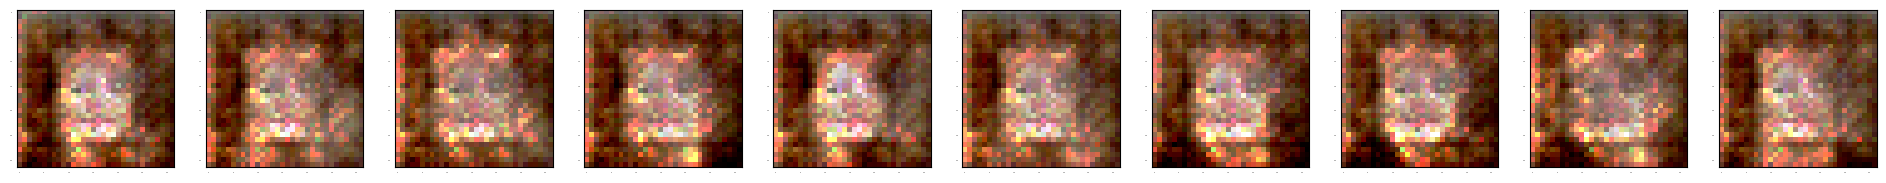

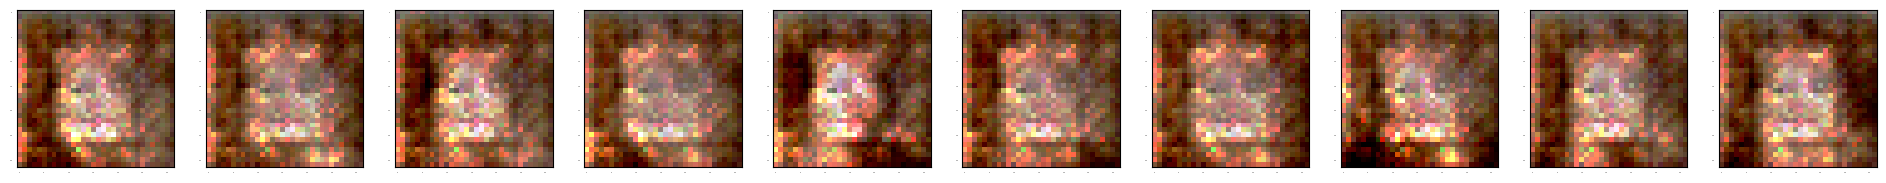

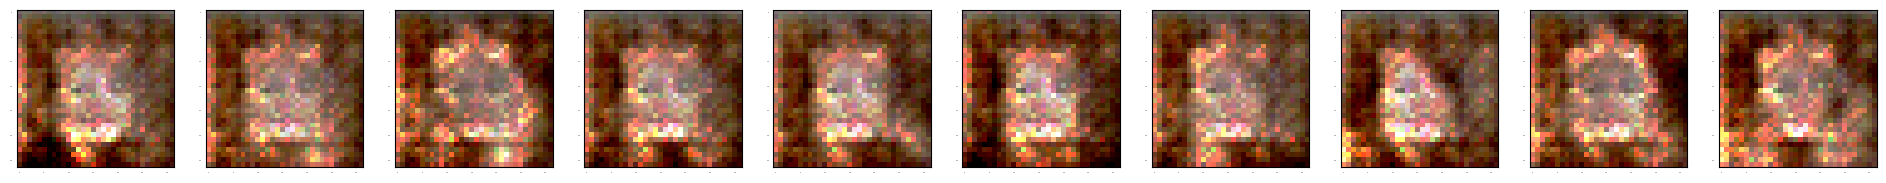

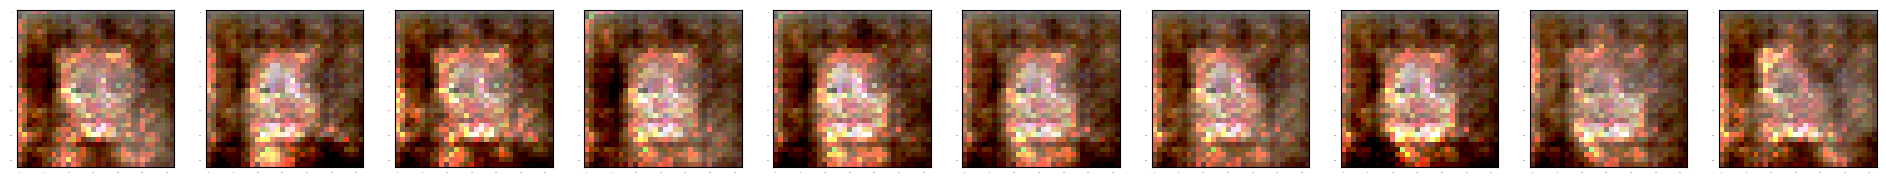

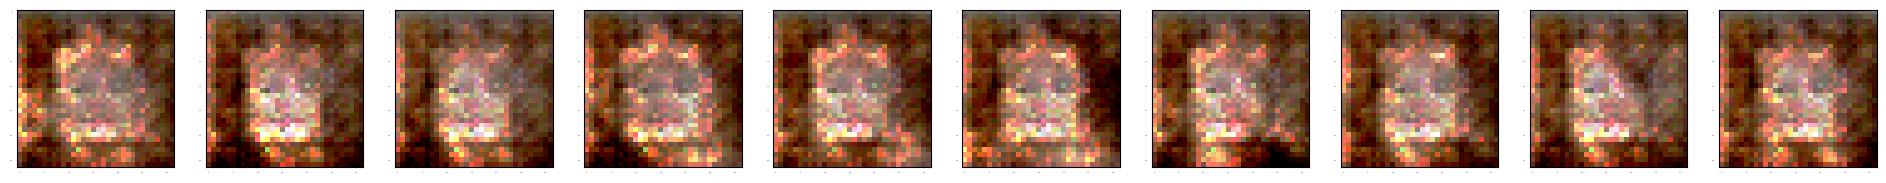

In [15]:
for _ in range(5):
    num_sample = 10
    z_test = np.random.uniform(-1.0, 1.0, (num, )+latent_dim).astype("float32")
    pred = gen.predict(z_test[:num_sample]).reshape(-1, img_dim, img_dim, 3)

    _, axs = plt.subplots(1,num_sample, figsize=(24,12))
    for i in range(num_sample):
        img = np.clip((pred[i]+1)*(255/2), 0, 255).astype("uint32")
        axs[i].imshow(img)
        axs[i].tick_params(length=0, labelsize=0)